1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import pandas as pd
import math as m
from matplotlib.ticker import MaxNLocator
import matplotlib.pyplot as plt
import scipy
from scipy.stats import norm
import seaborn as sns

%matplotlib inline

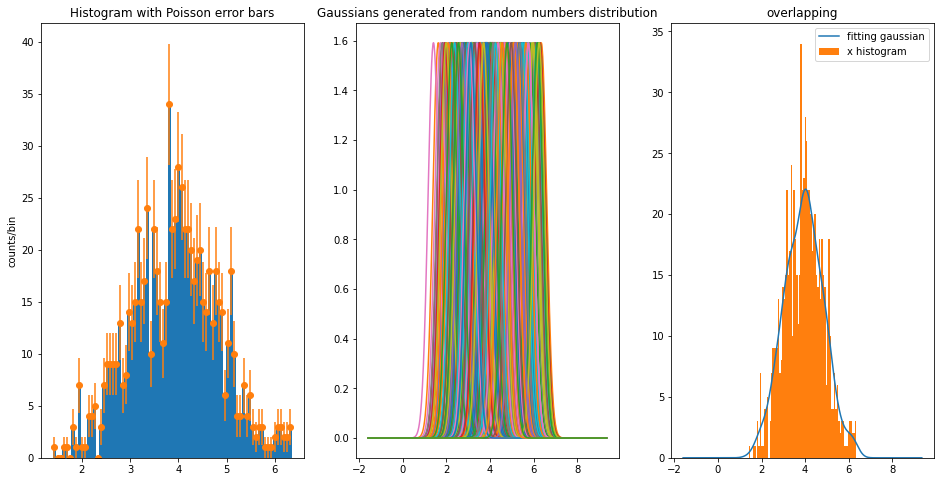

In [2]:
np.random.seed(1998)
N=np.random.randint(100, 800)
mean=np.random.randint(3, 9)
std=np.random.random()
x = np.random.normal(mean, std, N)

fig, (ax, ax1, ax2) = plt.subplots( 1, 3, figsize=(16,8))
n, bins, patches  = ax.hist(x, bins=int (N/10), label='x')
binstep = bins[1]-bins[0]
ax.set_ylabel("counts/bin")
ax.set_title('Histogram with Poisson error bars')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
bincenters = 0.5 * (bins[1:]+bins[:-1])
ax.errorbar(bincenters, n, yerr = np.sqrt(n), fmt='o')


mesh = np.linspace(bins.min()-3, bins.max()+3, num=N)

gaussians = np.zeros((N, N))
standard_sigma = 1.06 * x.std()* m.pow( x.size, -1/5 )

for i in range(N):
    gauss = norm (x[i], standard_sigma )
    lp = np.linspace(gauss.ppf(0.001), gauss.ppf(0.999), N)
    gaussians[i, :] = gauss.pdf(mesh)
    ax1.plot(mesh, gauss.pdf(mesh))

ax1.set_title('Gaussians generated from random numbers distribution')




gauss_sum = np.sum(gaussians, axis=0)
gauss_sum =  ( gauss_sum ) * N * binstep / scipy.integrate.trapz(gauss_sum, mesh) 
ax2.plot(mesh, gauss_sum, label='fitting gaussian')
ax2.hist(x, bins=int (N/10), label='x histogram')
ax2.set_title('overlapping')
ax2.legend(loc='best')
plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

<AxesSubplot:xlabel='x', ylabel='y'>

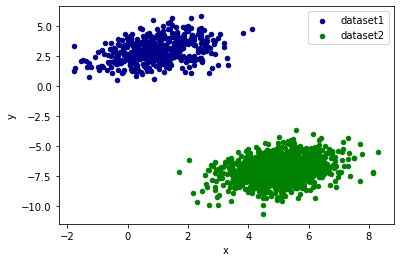

In [3]:
mean1, cov1 = [1, 3],  [(1, 0.3), (0.3, 1)]
mean2, cov2 = [5, -7], [(1,0.3), (0.3, 1)]
data1 = np.random.multivariate_normal(mean1, cov1, 500)
data2 = np.random.multivariate_normal(mean2, cov2, 1000)

df1 = pd.DataFrame(data1, columns=['x', 'y'])
df2 = pd.DataFrame(data2, columns=['x', 'y'])

ax = df1.plot.scatter(x='x', y='y', c='DarkBlue', label='dataset1')
df2.plot.scatter(x='x', y='y', c='Green', label='dataset2', ax=ax)

In [ ]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

0.003259770122030583 -0.15432816763069473


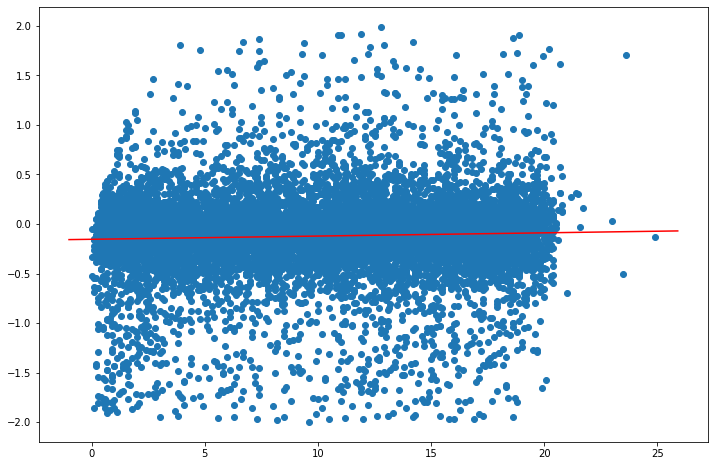

<AxesSubplot:xlabel='distances', ylabel='residuals'>

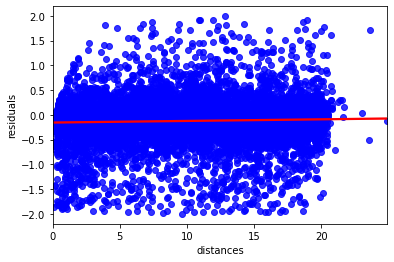

In [4]:
#! wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy -P ~/data/
data = np.load('residuals_261.npy', allow_pickle=True)
df = pd.DataFrame(data.item())
df = df[abs(df['residuals'])<2]


#linear regression with scipy
slope, intercept, rvalue, pvalue, stderr = scipy.stats.linregress(df['distances'], df['residuals'])
print(slope, intercept)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(df['distances'], df['residuals'], 'o')
lp = np.linspace(df['distances'].min()-1, df['distances'].max()+1, 1000)
ax.plot(lp, intercept+slope*lp, color='Red')
plt.show()

#linear regression with seaborn
sns.regplot(x='distances', y='residuals', data=df, scatter_kws={"color": "blue"}, line_kws={"color": "red"})


In [8]:
bins = np.linspace(0, 20, 7)
df['bin'] = np.digitize(df.distances, bins=bins)
print(df.bin.min(), df.bin.max())

#bins = np.linspace(0, 20, 7)
#df['bin'] =np.digitize(df['distances'], bins=bins)
print(df)
x = 0.5 * (bins[:-1] + bins[1:])
grouped = df.groupby('bin')
y=grouped['residuals'].mean()
erry = df.groupby('bin')['residuals'].std()




result = pd.DataFrame()

#result['x']=x
#result['y']=y
#result['erry']=erry



#result.plot(x='x', y='y', yerr='erry',   capsize=0,
   # color='black')

1 7
       residuals  distances  bin
0       1.100000       16.0    5
1      -1.950000        6.3    2
8      -0.042857        3.3    1
9       0.128571        5.3    2
10      0.085714       15.0    5
...          ...        ...  ...
11126  -0.760000       14.4    5
11127   0.380000        7.5    3
11128   0.083333        1.7    1
11129   0.166667       19.1    6
11130   0.083333        2.6    1

[10489 rows x 3 columns]
<bound method NDFrame.tail of 0        5
1        2
8        1
9        2
10       5
        ..
11126    5
11127    3
11128    1
11129    6
11130    1
Name: bin, Length: 10489, dtype: int64>


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# just some random numbers to get startet
x = np.random.uniform(-2, 2, 10000)
y = np.random.normal(x**2, np.abs(x) + 1)
df = pd.DataFrame({'x': x, 'y': y})


# calculate in which bin row belongs base on `x`
# bins needs the bin edges, so this will give as 100 equally sized bins
bins = np.linspace(-2, 2, 101)
df['bin'] = np.digitize(df.x, bins=bins)
print(df.bin.max(), df.bin.min())
print(df)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
bin_width = bins[1] - bins[0]

# grouby bin, so we can calculate stuff
binned = df.groupby('bin')
# calculate mean and standard error of the mean for y in each bin
result = binned['y'].agg(['mean', 'sem'])

print(len(bin_centers), len(result['mean']))
result['x'] = bin_centers
result['xerr'] = bin_width / 2
print(result)
# plot it

result.plot(
    x='x',
    y='mean',
    xerr='xerr',
    yerr='sem',
    linestyle='none',
    capsize=0,
    color='black',
)
plt.savefig('result.png', dpi=300)